---

## [HW01] AutoEncoderLightning


`[HW01] Autoencoder`에서 진행한 내용을 [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/)을 이용해 재구현하도록 한다.

- PyTorch Lightning은 반복적인 코드를 줄이고, 더 깔끔하고 구조화된 방식으로 딥러닝 모델을 개발할 수 있도록 도와주는 프레임워크이다.
- 사용 방법은 [여기](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)를 참고하도록 하자.

---

# PyTorch Lightning 설치

In [1]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 필요한 모듈 임포트

In [2]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

import lightning as L                             # PyTorch Ligthning 모듈 임포트

from tqdm import tqdm

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.

Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Numpy: 2.0.2
Torch:  2.6.0+cu124
Torchvision:  0.21.0+cu124


## Hyperparameter 설정
* batch size, learning rate, epoch을 설정
* 잠재 벡터(latent vector) $z$의 크기 설정

In [446]:
batch_size    = 100
learning_rate = 0.002
n_dim = 3

# 데이터셋

In [479]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

download_root = './MNIST_DATASET'

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(download_root,
                      transform=mnist_transform,
                      train=True,
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform,
                     train=False,
                     download=False)

## MNIST DataLoader 정의

[파이토치 데이터로더](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)는 데이터셋을 배치단위로 묶어 순회(iteration)할 수 있도록 한다.

아래 코드는 데이터셋에 대한 데이터로더를 만들고, 각 배치가 어떤 텐서 형태로 구성되어 있는지 확인하는 코드이다.
* 데이터로더에서는 이미지들이 배치단위로 묶였기 때문에, B x C x H x W 모양(shape)의 텐서이며, 데이터타입(dtype)은 `torch.float32`가 되었음을 확인하자.
* 데이터로더에서는 레이블들이 배치단위로 묶였기 때문에, B 모양(shape)의 텐서이며, 데이터타입(dtype)은 `torch.int64`가 되었음을 확인하자.

train_dataset과 test_dataset은 동일 형태이므로, train_dataset의 데이터로더에 대해서만 확인하였다.


In [448]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

## 네트워크 모델 설계
* 인코더 모델: `torch.nn.Sequential` 모듈로 모델로 설계
  + InputLayer로 (1,28,28) 영상을 받고, Linear 레이어를 여럿 통과시킨 후, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: `torch.nn.Sequential` 모듈로 모델로 설계
  + InputLayer에서 n_dim차원 벡터를 받고, Linear 레이어를 여럿 통과시킨 후, 출력으로 (1,28,28) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계

### 인코더 모델 정의
* (1, 28, 28) 영상을 입력으로 받도록 입력 레이어 정의
* Flatten으로 입력 텐서를 784-vector로 벡터라이즈
* Fully connected layer로 784 > 256 > 128 > 32 > n_dim 로 차원 축소

### 디코더 모델 정의
* Fully connected layey로 n_dim > 32 > 128 > 256 > 784로 차원 확대
* 784-vector를 Reshape을 통해 (28, 28)의 텐서로 변환

In [449]:
enc = nn.Sequential(
  nn.Flatten(),
  nn.Linear(784, 256),
  nn.ReLU(),
  nn.Linear(256, 128),
  nn.ReLU(),
  nn.Linear(128, 32),
  nn.ReLU(),
  nn.Linear(32, n_dim)
)

dec = nn.Sequential(
    nn.Linear(n_dim, 32),
    nn.ReLU(),
    nn.Linear(32, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Unflatten(1, torch.Size([1, 28, 28])),
    nn.Sigmoid(),
)

# PyTorch Lightning을 사용한 모델 정의

- `LightningModule`을 서브클래싱한 AutoEncoder 클래스를 정의하자.
-  `AutoEncoder` 클래스 내부에 학습 루프, 최적화 설정 등을 모두 캡슐화하여 구현



In [450]:
# TODO

class AutoEncoder(L.LightningModule):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc
    self.dec = dec
    self.mse = nn.MSELoss()

  def training_step(self, batch, batch_idx):
    ## training step은 훈련 단계의 각 step에서 진행하는 일을 정의함.
    x, _ = batch
    result = self.forward(x)
    loss = self.mse(result, x)
    self.log("train_loss", loss)
    return loss # loss를 return 받으면 자동으로 역전파 진행해주기 때문에 특별한 경우가 아니면 backward를 명시해 적을 필요 없음
    # pass

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)
    return optimizer
    # pass

  def forward(self, x):
    z = self.enc(x)
    result = self.dec(z)
    return result
    # pass



# 모델 인스턴스 정의
- `AutoEncoder` 클래스의 인스턴스 `ae`를 정의한다.
- 모델 인스턴스 `ae`가 어떤 디바이스에 있는지 조사한다.

In [451]:
# init the autoencoder
ae = AutoEncoder(enc, dec)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
ae.to(device)
print(ae.device)

cuda:0


## 네트워크 모델 구조 확인
딥러닝 모델의 입출력 구조를 다음과 같이 확인한다.  여기서 중요한 사항은 다음을 확인하는 것이다.

1. 레이어의 연결구조,  
2. 레이어별 입출력 텐서의 차원,
3. 학습할 파라메터 개수

* Lightning이 모델을 어떤 디바이스에 보유하고 있는지 `device=str(ae.device)`로 확인하면서 사용해야 함.

In [452]:
!pip install torchsummary

In [453]:
print(ae.device)

cuda:0


In [454]:
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
summary(ae.to(device), (1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 32]           4,128
              ReLU-7                   [-1, 32]               0
            Linear-8                    [-1, 3]              99
            Linear-9                   [-1, 32]             128
             ReLU-10                   [-1, 32]               0
           Linear-11                  [-1, 256]           8,448
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 784]         201,488
        Unflatten-14            [-1, 1,

Lightning 모듈에서 지원하는 summarize() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.
* 모델이 어떤 디바이스에 있는지 신경쓸 필요 없음.
* 하지만 torchsummary 보다 간단한 방식으로만 확인 가능함.

In [455]:
from pytorch_lightning.utilities.model_summary import summarize

print(summarize(ae, max_depth=2))

   | Name  | Type       | Params | Mode 
----------------------------------------------
0  | enc   | Sequential | 238 K  | train
1  | enc.0 | Flatten    | 0      | train
2  | enc.1 | Linear     | 200 K  | train
3  | enc.2 | ReLU       | 0      | train
4  | enc.3 | Linear     | 32.9 K | train
5  | enc.4 | ReLU       | 0      | train
6  | enc.5 | Linear     | 4.1 K  | train
7  | enc.6 | ReLU       | 0      | train
8  | enc.7 | Linear     | 99     | train
9  | dec   | Sequential | 210 K  | train
10 | dec.0 | Linear     | 128    | train
11 | dec.1 | ReLU       | 0      | train
12 | dec.2 | Linear     | 8.4 K  | train
13 | dec.3 | ReLU       | 0      | train
14 | dec.4 | Linear     | 201 K  | train
15 | dec.5 | Unflatten  | 0      | train
16 | dec.6 | Sigmoid    | 0      | train
17 | mse   | MSELoss    | 0      | train
----------------------------------------------
448 K     Trainable params
0         Non-trainable params
448 K     Total params
1.793     Total estimated model params size (M

## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (1, 28, 28) -> ae -> (1, 28, 28)로 동작하지 않고,
    - batch 단위로 (?, 1, 28, 28) -> ae -> (?, 1, 28, 28)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 함수로서는 작동하지만 노이즈 출력만 나올 뿐, 정상적인 출력이 나오는 함수로 동작하지 않음.

In [456]:
# TODO
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  X      = torch.unsqueeze(image, 0).to(device)
  Y_pred = ae(X)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')

  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

## 딥러닝 모델 학습

Lightning의 `Trainer`를 만들고, `fit()` 함수를 통해 딥러닝 모델을 학습시킴.

In [457]:
# TODO
trainer = L.Trainer(max_epochs=20)

trainer.fit(ae, train_dataloaders=train_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | enc  | Sequential | 238 K  | train
1 | dec  | Sequential | 210 K  | train
2 | mse  | MSELoss    | 0      | train
--------------------------------------------
448 K     Trainable params
0         Non-trainable params
448 K     Total params
1.793     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
IN

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### 트레이닝셋을 이용해 학습 후 결과 시각화
학습이 끝난 autoencoder에 대해 train_dataset에 대한 결과 시각화

In [458]:
# TODO
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  (image, label) = train_dataset[idx]
  print('GT label:', label)

  ae.to(device)
  X = torch.unsqueeze(image, 0).to(device)
  Y_pred = ae(X)

  input_img  = to_pil_image(X.cpu().squeeze())
  output_img = to_pil_image(Y_pred.cpu().squeeze())

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')

  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

# 인코더 / 디코더 모델을 각각 따로 함수로서 활용하기
오토인코더 네트웍 전체가 아닌 `enc()` 부분과 `dec()` 부분을 각각 수행할 수 있다.
* 특정 예제에 대한 인코딩 결과와 디코딩 결과를 따로 확인한다.

GT label: 8
latent code z:  tensor([[0.7367, 2.1175, 0.7004]], device='cuda:0', grad_fn=<AddmmBackward0>)


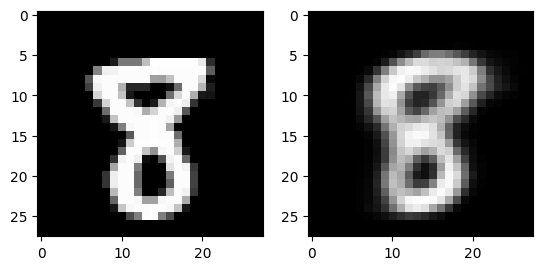

In [459]:
# TODO
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

idx = 128

(image, label) = test_dataset[idx]
print('GT label:', label)

X      = torch.unsqueeze(image, 0).to(device)
z      = enc(X)
Y_pred = dec(z)

print("latent code z: ", z)

input_img  = to_pil_image(X.squeeze())
output_img = to_pil_image(Y_pred.squeeze())

plt.subplot(121)
plt.imshow(input_img, cmap='gray')

plt.subplot(122)
plt.imshow(output_img, cmap='gray')

인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인

In [460]:
# TODO
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

u = widgets.FloatSlider(min=-10.0, max=10.0, step=0.1, description='u', orientation='horizontal')
v = widgets.FloatSlider(min=-10.0, max=10.0, step=0.1, description='v', orientation='horizontal')
w = widgets.FloatSlider(min=-10.0, max=10.0, step=0.1, description='w', orientation='horizontal')

ui = widgets.VBox([u, v, w])

def z_test(u, v, w):
    z_test = np.array([[u, v, w]])
    print("z:", z_test)

    z_test = torch.FloatTensor(z_test).to(device)

    ae.eval().to(device)
    img_gen = ae.dec(z_test)

    img_gen = to_pil_image(img_gen.squeeze())

    plt.imshow(img_gen, cmap='gray')
    plt.axis("off")
    plt.show()

out = widgets.interactive_output(z_test, {'u': u, 'v': v, 'w': w})
display(ui, out)

Output()

## TODO
1. encoder를 거쳐 나온 representation z를 GT label 별로 다른색을 주어 z의 분포를 가시화한다.
2. z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내는지 여부를 확인한다.
3. 만일 discriminative하지 않다면, autoencoder가 discriminative한 representation z를 학습하도록 z의 차원을 바꿔가면서 실험을 진행한다.
4. 결과에 대한 분석을 작성한다.

## 인코딩 결과 가시화
오토인코더의 encoder가 만들어 내는 representation인 z 값을 가시화 한다.

## 가시화 결과

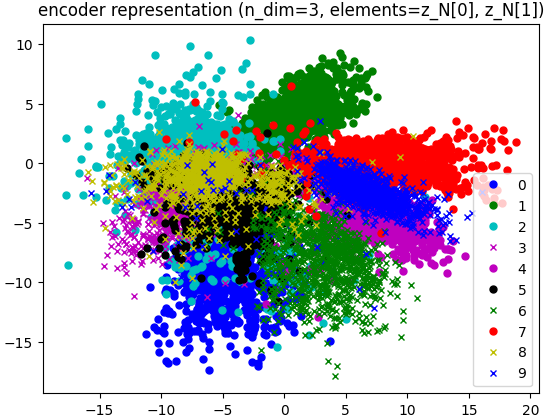

## 결과 분석

n_dim = 3이므로 결과로 나온 3차원 벡터의 인덱스 0, 1을 2차원으로 투영하여 가시화를 진행하였다.

학습을 진행한 결과 각 클래스 별로 잘 모여있지만, 비슷한 모양을 가지는 클래스들이 모여있고 plot함수를 작성하면 이전에 그려진 라벨 위에 새로운 라벨이 덮어져 가려지는 부분이 있다.

전체적으로 라벨 8이 있는 부분이 라벨 3, 0과 겹쳐있는 부분이고 라벨 9와 라벨 7, 4와 겹쳐있는 것을 확인 가능한데, 이는 비슷한 모양을 가지는 이미지는 비슷한 벡터를 가진다는 것을 의미한다.

또한 n_dim이 3이기 때문에 현재 시각화에 있는 x, y축 말고 z축까지 함께 시각화를 하면 더욱 discrimitive한 결과를 낼 수 있을 것이라는 생각이 든다.

torch.Size([980, 3])
torch.Size([1135, 3])
torch.Size([1032, 3])
torch.Size([1010, 3])
torch.Size([982, 3])
torch.Size([892, 3])
torch.Size([958, 3])
torch.Size([1028, 3])
torch.Size([974, 3])
torch.Size([1009, 3])


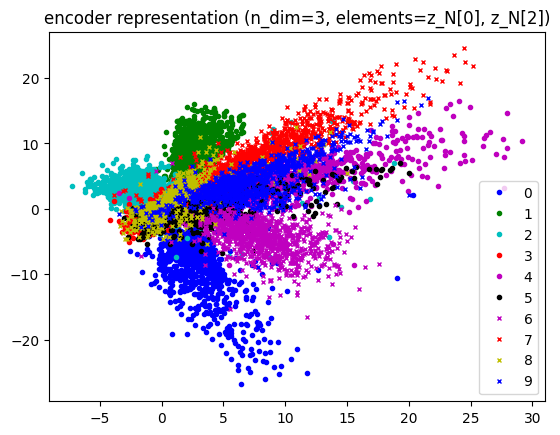

In [465]:
# TODO
import matplotlib.pyplot as plt

whole_test_loader = DataLoader(dataset=test_dataset,
                               batch_size=len(test_dataset),
                               shuffle=False)
whole_test_images, whole_test_labels = next(iter(whole_test_loader))

whole_test_images = whole_test_images.to(device)
whole_test_labels = whole_test_labels.to(device)

z = enc(whole_test_images)

z_0 = z[whole_test_labels==0]
z_1 = z[whole_test_labels==1]
z_2 = z[whole_test_labels==2]
z_3 = z[whole_test_labels==3]
z_4 = z[whole_test_labels==4]
z_5 = z[whole_test_labels==5]
z_6 = z[whole_test_labels==6]
z_7 = z[whole_test_labels==7]
z_8 = z[whole_test_labels==8]
z_9 = z[whole_test_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_3.shape)
print(z_4.shape)
print(z_5.shape)
print(z_6.shape)
print(z_7.shape)
print(z_8.shape)
print(z_9.shape)

first = 0
second = 2

plt.title(f'encoder representation (n_dim={n_dim}, elements=z_N[{first}], z_N[{second}])')
plt.plot(z_0[:,first].detach().cpu().numpy(), z_0[:,second].detach().cpu().numpy(), 'bo', markersize=3, label="0")
plt.plot(z_1[:,first].detach().cpu().numpy(), z_1[:,second].detach().cpu().numpy(), 'go', markersize=3, label="1")
plt.plot(z_2[:,first].detach().cpu().numpy(), z_2[:,second].detach().cpu().numpy(), 'co', markersize=3, label="2")
plt.plot(z_3[:,first].detach().cpu().numpy(), z_3[:,second].detach().cpu().numpy(), 'ro', markersize=3, label="3")
plt.plot(z_4[:,first].detach().cpu().numpy(), z_4[:,second].detach().cpu().numpy(), 'mo', markersize=3, label="4")
plt.plot(z_5[:,first].detach().cpu().numpy(), z_5[:,second].detach().cpu().numpy(), 'ko', markersize=3, label="5")
plt.plot(z_6[:,first].detach().cpu().numpy(), z_6[:,second].detach().cpu().numpy(), 'mx', markersize=3, label="6")
plt.plot(z_7[:,first].detach().cpu().numpy(), z_7[:,second].detach().cpu().numpy(), 'rx', markersize=3, label="7")
plt.plot(z_8[:,first].detach().cpu().numpy(), z_8[:,second].detach().cpu().numpy(), 'yx', markersize=3, label="8")
plt.plot(z_9[:,first].detach().cpu().numpy(), z_9[:,second].detach().cpu().numpy(), 'bx', markersize=3, label="9")
plt.legend()

## TODO: 디코더를 이용한 Generative Model 구성
1. z 공간의 임의의 위치를 sampling한 후, 이를 decoder의 입력으로 주는 방식으로 generative model을 구축한다.
2. 결과로 만들어지는 이미지는 어떤 특징을 가지고 있는지 분석한다.

## 샘플링한 z를 이용해 이미지 생성 결과

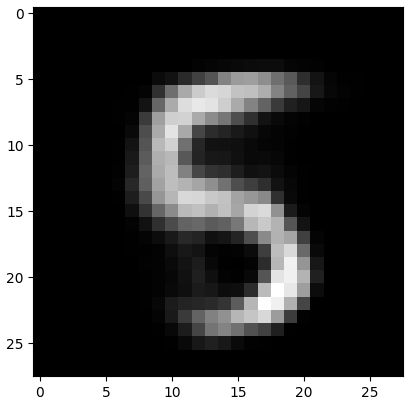

## 결과 분석

생성 이미지를 보았을 떄, 라벨 5의 모습을 하고 있다.

하지만 아래 왼쪽 부분에 희미한 회색 줄이 있는걸 볼 수 있고, 이는 라벨 6과 비슷하다는 것으로 볼 수 있다.

이는 784차원의 수를 n_dim차원의 벡터로 변환하는 과정에서 모양이 비슷한 입력 이미지에 대해 유사한 z를 가지게 되기 때문이라고 생각한다. 이로 인해 기존 입력 이미지보다 부드러운 이미지를 갖게 된다는 것을 알 수 있다.

정규분포 랜덤추출로 z벡터를 추출 및 decoder에 적용하였기 때문에 여러 이미지가 가지는 특징이 있는 위치에 벡터가 존재할 가능성이 크다. 위의 z벡터 가시화와 같이 특정 라벨값만 존재하는 z벡터 값을 decoder에 넣으면 더욱 확실한 결과가 나올 것이라고 확신한다.

In [477]:
## TODO
z = np.random.randn(1, n_dim)

z = torch.FloatTensor(z).to(device)
result = dec(z)

print(z.shape)
print(result.shape)
print(result.min(), result.max())

torch.Size([1, 3])
torch.Size([1, 1, 28, 28])
tensor(5.5360e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8582, device='cuda:0', grad_fn=<MaxBackward1>)


결과 가시화

z : tensor([[ 0.7597,  0.3356, -0.7622]], device='cuda:0')


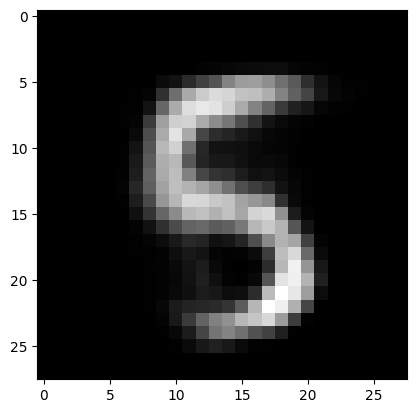

In [478]:
## TODO
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

print(f"z : {z}")

img = to_pil_image(result.squeeze())
plt.imshow(img, cmap='gray')
plt.show()